<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Tutorial sobre cómo generar una explicación para un modelo basado en imágenes en Watson OpenScale

Este notebook incluye pasos para crear un modelo de Watson-machine-learning basado en imágenes, crear una suscripción, configurar explicabilidad y, finalmente, generar una explicación para una transacción.

### Contenido
- [1. Instalación](#setup)
- [2. Creando y desplegando un modelo de imágenes](#deployment)
- [3. Suscripciones](#subscription)
- [4. Explicabilidad](#explainability)

**Nota**: Si usa Watson Studio, intente ejecutar el portátil en al menos la versión 'Default Python 3.5 XS' para obtener resultados más rápidos.

<a id="setup"></a>
## 1. Instalación

### 1.1 Instala los paquetes de Watson OpenScale y WML 

In [1]:
!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1

In [2]:
!pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1

Nota: Reinicie el kernel para asegurarse de que se estén utilizando las nuevas bibliotecas.

### 1.2 Configura las credenciales

Obtenga la `apikey` de Watson Openscale yendo a la [Consola Bluemix] (https://console.bluemix.net/) y haciendo clic en` Administrar-> Cuenta-> Usuarios`. Seleccione "Claves API de plataforma" en la barra lateral y luego haga clic en el botón "Crear".

Se puede obtener el `instancia_id` de Watson OpenScale (guid) accediendo a la [consola en la nube] (https://cloud.ibm.com/resources), haciendo clic en` Servicios` y haciendo clic en cualquier parte del mosaico de servicio de Watson OpenScale, excepto el enlace de servicio y luego verificando la barra lateral emergente a la derecha.

In [3]:
AIOS_CREDENTIALS = {
    "instance_guid": "",
    "apikey": "", 
    "url": ""
}

Genere o busque las credenciales WML haciendo clic en `Credenciales` en la barra lateral de la página WML aprovisionada y péguela a continuación.

In [51]:
WML_CREDENTIALS = {
  
}

<a id="deployment"></a>
## 2. Crear e implementar un modelo basado en imágenes

El conjunto de datos utilizado es el conjunto de datos MNIST de dígitos escritos a mano. Consiste en 60,000 imágenes en escala de grises de 28x28 de los 10 dígitos, junto con un conjunto de prueba de 10,000 imágenes. Puede encontrar más información sobre el conjunto de datos aquí: https://keras.io/datasets/#mnist-database-of-handwritten-digits

Nota: Las versiones de Keras y TensorFlow compatibles con WML son: Keras 2.1.6 con el backend TensorFlow 1.13 y Keras 2.2.4 con el backend TensorFlow 1.14. La última combinación se usa en este notebook

### 2.1 Creando el modelo

In [5]:
!pip install keras==2.2.4
!pip install tensorflow==1.14.0
!pip install keras_sequential_ascii

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as keras_backend
print(keras.__version__)

     |████████████████████████████████| 109.2MB 52.2MB/s eta 0:00:01   |████████████████▋               | 56.8MB 47.6MB/s eta 0:00:02
     |████████████████████████████████| 61kB 26.0MB/s eta 0:00:01
     |████████████████████████████████| 3.2MB 44.2MB/s eta 0:00:01
     |████████████████████████████████| 491kB 36.8MB/s eta 0:00:01
     |████████████████████████████████| 583kB 45.1MB/s eta 0:00:01
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


Using TensorFlow backend.


2.2.4


In [6]:
batch_size = 128
num_classes = 10
epochs = 5

In [7]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras_backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [8]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
# Define Model

def base_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [10]:
cnn_n = base_model()
cnn_n.summary()

W0401 18:48:38.274579 140441764169536 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0401 18:48:38.298037 140441764169536 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0401 18:48:38.300992 140441764169536 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0401 18:48:38.334041 140441764169536 deprecation_wrapper.py:119] From /opt/conda/envs/Python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [11]:
# Vizualizing model structure
sequential_model_to_ascii_printout(cnn_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       320     0.0%
                relu   #####     26   26   32
              Conv2D    \|/  -------------------     18496     1.5%
                relu   #####     24   24   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   64
             Dropout    | || -------------------         0     0.0%
                       #####     12   12   64
             Flatten   ||||| -------------------         0     0.0%
                       #####        9216
               Dense   XXXXX -------------------   1179776    98.3%
                relu   #####         128
             Dropout    | || -------------------         0     0.0%
                       #####         128
               Dense   XXXXX -------------------      1290     0.1%
             softmax   ##### 

In [12]:
# Fit model
print(y_train.shape)
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

W0401 18:48:38.583369 140441764169536 deprecation.py:323] From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(60000, 10)
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 169s 3ms/step - loss: 0.2650 - acc: 0.9192 - val_loss: 0.0552 - val_acc: 0.9827
Epoch 2/5
60000/60000 [==============================] - 169s 3ms/step - loss: 0.0874 - acc: 0.9747 - val_loss: 0.0384 - val_acc: 0.9877
Epoch 3/5
60000/60000 [==============================] - 174s 3ms/step - loss: 0.0645 - acc: 0.9804 - val_loss: 0.0355 - val_acc: 0.9872
Epoch 4/5
60000/60000 [==============================] - 171s 3ms/step - loss: 0.0543 - acc: 0.9840 - val_loss: 0.0322 - val_acc: 0.9887
Epoch 5/5
60000/60000 [==============================] - 173s 3ms/step - loss: 0.0455 - acc: 0.9861 - val_loss: 0.0280 - val_acc: 0.9909


In [13]:
scores = cnn_n.evaluate(x_test, y_test, verbose=0)
print(scores)
print("Accuracy: %.2f%%" % (scores[1]*100))

[0.027997173377852597, 0.9909]
Accuracy: 99.09%


### 2.2 Almacenando el modelo

In [14]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)
cnn_n.save("mnist_cnn.h5")
!rm mnist_cnn.tar*
!tar -czvf mnist_cnn.tar.gz mnist_cnn.h5

rm: cannot remove ‘mnist_cnn.tar*’: No such file or directory
mnist_cnn.h5


In [15]:
!rm mnist_cnn.h5

In [16]:
model_name = "MNIST Model"

# Update the FRAMEWORK_VERSION below depending on the tensorflow version used
model_meta = {
    wml_client.repository.ModelMetaNames.NAME: model_name,
    wml_client.repository.ModelMetaNames.DESCRIPTION: "MNIST model",
    wml_client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    wml_client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.14",
    wml_client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [
         {"name": "keras", "version": "2.2.4"}
    ]
}

In [17]:
published_model_details = wml_client.repository.store_model(model='mnist_cnn.tar.gz', meta_props=model_meta)

In [18]:
model_uid = wml_client.repository.get_model_uid(published_model_details)
model_uid

'11e02e65-97eb-4c37-8322-f4384b8a9caf'

### 2.3 Desplegando el modelo

In [19]:
deployment= wml_client.deployments.create(name= model_name + " Deployment", model_uid=model_uid)



#######################################################################################

Synchronous deployment creation for uid: '11e02e65-97eb-4c37-8322-f4384b8a9caf' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='b8a6f80c-c301-4f94-a335-8412e13e978c'
------------------------------------------------------------------------------------------------




In [20]:
scoring_url = wml_client.deployments.get_scoring_url(deployment)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/197aa151-8d29-4a35-af88-cfc689f25d87/deployments/b8a6f80c-c301-4f94-a335-8412e13e978c/online


## 3. Suscripciones

### 3.1 Configurando OpenScale

In [28]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import WatsonMachineLearningAsset

aios_client = APIClient(AIOS_CREDENTIALS)
aios_client.version

'2.2.1'

### 3.2 Suscribir el asset

In [29]:
from ibm_ai_openscale.supporting_classes import *

subscription = aios_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.MULTICLASS_CLASSIFICATION,
    input_data_type=InputDataType.UNSTRUCTURED_IMAGE,
    probability_column='probability'
))

In [40]:
aios_client.data_mart.subscriptions.list()

827b02c8-3b2a-483f-ba3c-b46b0d736b44,MNIST Model,model,197aa151-8d29-4a35-af88-cfc689f25d87,2020-04-01T19:05:10.255Z
eadd87e5-de57-4a35-8ee5-0a9530080c2c,Scikit German Risk Model,model,197aa151-8d29-4a35-af88-cfc689f25d87,2020-04-01T14:03:18.183Z


In [41]:
subscription.get_details()

{'entity': {'asset': {'asset_id': '11e02e65-97eb-4c37-8322-f4384b8a9caf',
   'asset_type': 'model',
   'created_at': '2020-04-01T19:03:40.104Z',
   'name': 'MNIST Model',
   'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/197aa151-8d29-4a35-af88-cfc689f25d87/published_models/11e02e65-97eb-4c37-8322-f4384b8a9caf'},
  'asset_properties': {'input_data_type': 'unstructured_image',
   'model_type': 'tensorflow-1.14',
   'output_data_schema': {'fields': [{'metadata': {'modeling_role': 'record-id',
       'primary_key': True},
      'name': 'scoring_id',
      'nullable': False,
      'type': 'string'},
     {'metadata': {'modeling_role': 'record-timestamp'},
      'name': 'scoring_timestamp',
      'nullable': False,
      'type': 'timestamp'},
     {'metadata': {},
      'name': 'deployment_id',
      'nullable': False,
      'type': 'string'},
     {'metadata': {},
      'name': 'asset_revision',
      'nullable': True,
      'type': 'string'},
     {'metadata': {},
      'name'

### 3.3 Evalua el modelo y obtenga la identificación de transacción

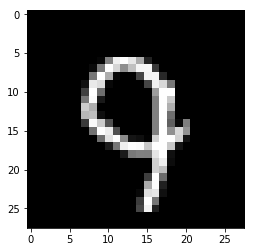

In [42]:
!pip install numpy
!pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
img = np.array(x_test[999], dtype='float')
pixels = img.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [43]:
scoring_data = {'values': [x_test[999].tolist()]}
predictions = wml_client.deployments.score(scoring_url, scoring_data)
print(predictions)

{'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[1.4399628867067804e-07, 7.403949675577337e-10, 2.0978516701575245e-08, 1.9271801647846587e-06, 0.0002658492012415081, 2.5246422410418745e-06, 9.68080282603978e-10, 2.3664482796448283e-05, 0.00010186623694607988, 0.9996040463447571], 9, [1.4399628867067804e-07, 7.403949675577337e-10, 2.0978516701575245e-08, 1.9271801647846587e-06, 0.0002658492012415081, 2.5246422410418745e-06, 9.68080282603978e-10, 2.3664482796448283e-05, 0.00010186623694607988, 0.9996040463447571]]]}


Note: Please wait for a few seconds before running the cell below.

In [44]:
transaction_id = subscription.payload_logging.get_table_content().scoring_id[0]
print(transaction_id)

2534e0bf6338443874854c46076e9335-1


<a id="explainability"></a>
## 4. Explicabilidad

### 4.1 Configurar la Explicabilidad

In [45]:
subscription.explainability.enable()

In [46]:
subscription.explainability.get_details()

{'enabled': True,
 'monitor_definition': {'entity': {'applies_to': {'input_data_type': ['structured',
     'unstructured_image',
     'unstructured_text'],
    'problem_type': ['binary', 'multiclass', 'regression']},
   'description': 'Provides explanations to the predictions made by a Machine Learning model.',
   'metrics': [],
   'monitor_runtime': {'type': 'service'},
   'name': 'Explainability',
   'parameters_schema': {'properties': {'tokenizer': {'$id': '#/properties/tokenizer',
      'items': {'$id': '#/properties/tokenizer/items',
       'properties': {'enabled': {'$id': '#/properties/tokenizer/items/properties/enabled',
         'type': 'boolean'},
        'language': {'$id': '#/properties/tokenizer/items/properties/language',
         'type': 'string'},
        'part_of_speech': {'$id': '#/properties/tokenizer/items/properties/part_of_speech',
         'items': {'oneOf': [{'type': 'string'}]},
         'type': 'array'}},
       'required': ['enabled'],
       'title': 'The to

### 4.2 Obtener explicaciones para la transacción

In [47]:
explanation = subscription.explainability.run(transaction_id, background_mode=False)




 Looking for explanation for 2534e0bf6338443874854c46076e9335-1 




in_progress..
finished

---------------------------
 Successfully finished run 
---------------------------




In [48]:
explanation

{'metadata': {'created_at': '2020-04-01T19:07:19.097249Z',
  'updated_at': '2020-04-01T19:07:39.712227Z',
  'created_by': 'IBMid-2700057BDV',
  'id': '541bc376-be90-4a83-a724-500d5f831497'},
 'entity': {'explanation_type': 'lime',
  'asset': {'type': 'image',
   'name': 'MNIST Model',
   'deployment': {'name': 'MNIST Model Deployment',
    'id': 'b8a6f80c-c301-4f94-a335-8412e13e978c'},
   'problem_type': 'multiclass',
   'id': '11e02e65-97eb-4c37-8322-f4384b8a9caf',
   'input_data_type': 'unstructured_image'},
  'input_features': [{'full_image': 'iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAIAAAD9b0jDAAABsUlEQVR42u2VLavCYBTHdxfGNoRniANBg9iMYtAyMWhXsBsNwpovKwat4ifQL+C0GQ1LDgy+gWDRoPCIIDKHW1HObrBc8OXeeZcu9x/Py48H/uechyD+9a9HoiiqVqtpmgYAGONOpxMMBn9FZFlWkiQAWCwWzWZTURTDMEzTjMVi70MrlYplWb1ej2GYWySZTOq6bhhGKBR6h8hx3H6/X61WNE1/jadSKV3Xl8tluVy2DU0kEgAgiuJ9qt1uAwAAvGgnH0aj0ej1epVl+T613W4JghiNRrah2Wy23+/vdrtnbRhj29DD4YAQQgg9a1MUxTa0Xq8LgjAYDDKZzMOC0+nEMEy1WrUBHQ6HkiRFIpFWq5VOp+8LwuHweDzmed72DIiiuNlsAKDRaPA

### Las imágenes explicativas se pueden obtener usando las celdas a continuación

In [49]:
!pip install Pillow
from PIL import Image
import base64
import io

img = explanation["entity"]["predictions"][0]["explanation"][0]["full_image"]
img_data = base64.b64decode(img)
Image.open(io.BytesIO(img_data))

In [50]:
img = explanation["entity"]["predictions"][1]["explanation"][0]["full_image"]
img_data = base64.b64decode(img)
Image.open(io.BytesIO(img_data))